In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

output_directory = "../data/final" 
file_path = os.path.join(output_directory, "merged_complete_preprocessed.csv")
df = pd.read_csv(file_path)
df_zh = df[df['Region'] == 'ZH']
df_zh.set_index('Year', inplace=True)
df_zh.drop('Region', axis=1, inplace=True)

for column in df_zh.columns:
    plt.figure(figsize=(10, 6))  
    plt.plot(df_zh.index, df_zh[column], marker='o', linestyle='-', label=column)
    plt.title(f'{column} over Time for Canton ZH (2013-2021)')
    plt.xlabel('Year')
    plt.ylabel(column)
    plt.grid(True)
    plt.legend()
    plt.show()


In [2]:
output_directory = "../data/final" 
file_path = os.path.join(output_directory, "merged_double_digit.csv")
df = pd.read_csv(file_path)
#print uniques values for Region and Year
print(df['Region'].unique())
print(df['Year'].unique())

In [3]:
import pandas as pd
import os

output_directory_final = "../data/final"
file_path_double_digit = os.path.join(output_directory_final, "merged_double_digit.csv")
output_directory_merged = "../data/merged_canton" 
file_path_kantonsdaten_merged = os.path.join(output_directory_merged, "Kantonsdaten_2013_to_2021_merged.csv")

df_double_digit = pd.read_csv(file_path_double_digit)
df_kantonsdaten = pd.read_csv(file_path_kantonsdaten_merged)


merged_df = pd.merge(df_double_digit, df_kantonsdaten, how='outer', left_on=['Region', 'Year'], right_on=['Canton', 'Year'])
# merged_df.fillna(0, inplace=True)
merged_df = merged_df[merged_df['Region'] != 0]
merged_df.drop('Canton', axis=1, inplace=True)


merged_output_path = os.path.join(output_directory_final, "merged_complete.csv")
merged_df.to_csv(merged_output_path, index=False)


In [4]:
merged_df.info()

In [5]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy import stats

# Load the dataset
df = pd.read_csv('../data/final/merged_complete.csv')

#delete all the rows where Realized	Budget y	Budget y+1	Slack are all 0
df = df[(df['Realized'] != 0) | (df['Budget y'] != 0) | (df['Budget y+1'] != 0) | (df['Slack'] != 0)]
# # Exclude Year from numeric columns for preprocessing
# exclude_columns = ['Year', 'Acc-ID', 'Realized', 'Budget y', 'Budget y+1', 'Slack']
# 
# numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col not in exclude_columns]
# 
# 
# # Apply median imputation to the selected numeric columns
# imputer = SimpleImputer(strategy='median')
# df[numeric_columns] = imputer.fit_transform(df[numeric_columns])
# 
# # Detect outliers based on the selected numeric columns (don't remove yet)
# z_scores = np.abs(stats.zscore(df[numeric_columns]))
# outliers = (z_scores < 3).all(axis=1)
# 
# # Keep a copy of the DataFrame with outliers removed
# df_no_outliers = df[outliers].copy()
# 
# # Apply scaling
# scaler = StandardScaler()
# df_no_outliers[numeric_columns] = scaler.fit_transform(df_no_outliers[numeric_columns])
# 
# # Apply transformation to make data more Gaussian-like
# transformer = PowerTransformer()
# df_no_outliers[numeric_columns] = transformer.fit_transform(df_no_outliers[numeric_columns])




# Save the preprocessed DataFrame with both numeric and categorical data
df.to_csv('../data/final/merged_complete_preprocessed.csv', index=False)


In [ ]:
import pandas as pd

# Assuming your data is loaded into a DataFrame named df
df = pd.read_csv('../data/final/merged_complete.csv')

# Ensure 'Year' is sorted
df = df.sort_values(by=['Region', 'Year'])

# Identify rows for the years 2011, 2012, and 2022
years_of_interest = [2011, 2012, 2022]

# Define columns that won't be interpolated
columns_not_to_interpolate = ['Year', 'Region', 'Acc-ID', 'Realized', 'Budget y', 'Budget y+1', 'Slack']

# Perform group-wise forward fill followed by backward fill for each region
# This aims to fill missing values for the specific years where linear interpolation might not be applicable
for region in df['Region'].unique():
    for year in years_of_interest:
        # Select rows for the specific region and year
        mask = (df['Region'] == region) & (df['Year'] == year)
        # Apply forward fill followed by backward fill within the region for the target year
        df.loc[mask, :] = df.loc[mask, :].fillna(method='ffill').fillna(method='bfill')

# Check if any missing values remain for the specified years
missing_values_check = df[df['Year'].isin(years_of_interest)].isnull().sum()
print(missing_values_check)

df.to_csv('../data/final/merged_complete_preprocessed.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the data
df = pd.read_csv('../data/final/merged_complete.csv')
df = df.sort_values(by=['Region', 'Year'])

columns_to_fill = [col for col in df.columns if col not in ['Year', 'Region', 'Acc-ID', 'Realized', 'Budget y', 'Budget y+1', 'Slack']]

for column in columns_to_fill:
    df[column].replace(0, np.nan, inplace=True)

for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        not_null_region_df = region_df.dropna(subset=[column])
        
        if len(not_null_region_df) > 1:
            X = not_null_region_df[['Year']]
            y = not_null_region_df[column]
            
            model = LinearRegression()
            model.fit(X, y)
            
            missing_df = region_df[region_df[column].isnull()]
            if not missing_df.empty:
                predicted_values = model.predict(missing_df[['Year']])
                
                df.loc[missing_df.index, column] = predicted_values

df = df.dropna(subset=['Region'])
columns_to_drop = set()

for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        if region_df[column].isnull().all():
            columns_to_drop.add(column)

df.drop(columns=columns_to_drop, inplace=True)

columns_to_fill = [col for col in columns_to_fill if col not in columns_to_drop]

print(f"Dropped columns: {columns_to_drop}")

output_path = '../data/final/merged_complete_preprocessed.csv'
df.to_csv(output_path, index=False)

print(f"DataFrame with filled values for multiple columns, excluding dropped columns, saved to {output_path}.")


In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('../data/final/merged_complete.csv')
df = df.sort_values(by=['Region', 'Year'])

# List of columns to fill
columns_to_fill = [col for col in df.columns if col not in ['Year', 'Region', 'Acc-ID', 'Realized', 'Budget y', 'Budget y+1', 'Slack']]

# Replace 0 with NaN for specified columns
df[columns_to_fill] = df[columns_to_fill].replace(0, np.nan)

# Replace inf and -inf with NaN
df[columns_to_fill] = df[columns_to_fill].replace([np.inf, -np.inf], np.nan)

# Iterate through each region
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    region_df.set_index('Year', inplace=True)
    
    # Forward fill
    region_df[columns_to_fill] = region_df[columns_to_fill].ffill()
    
    # Backward fill
    region_df[columns_to_fill] = region_df[columns_to_fill].bfill()
    
    # Interpolate
    region_df[columns_to_fill] = region_df[columns_to_fill].interpolate(method='linear', limit_direction='both')
    
    # Assign filled data back to the original DataFrame
    df.loc[df['Region'] == region, columns_to_fill] = region_df[columns_to_fill].values

# Drop rows where 'Region' is NaN
df = df.dropna(subset=['Region'])

# Identify columns to drop if all values are NaN within a region
columns_to_drop = set()

for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        if region_df[column].isnull().all():
            columns_to_drop.add(column)

# Drop identified columns
df.drop(columns=columns_to_drop, inplace=True)

# Update the columns to fill
columns_to_fill = [col for col in columns_to_fill if col not in columns_to_drop]

print(f"Dropped columns: {columns_to_drop}")

# Save the preprocessed DataFrame
output_path = '../data/final/merged_complete_preprocessed.csv'
df.to_csv(output_path, index=False)

print(f"DataFrame with filled values for multiple columns, excluding dropped columns, saved to {output_path}.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor  # Import Random Forest Regressor

# Load the data
df = pd.read_csv('../data/final/merged_complete.csv')
df = df.sort_values(by=['Region', 'Year'])

# Define the columns you want to fill
columns_to_fill = [col for col in df.columns if col not in ['Year', 'Region', 'Acc-ID', 'Realized', 'Budget y', 'Budget y+1', 'Slack']]

# Convert 0.0 to NaN for specified columns
for column in columns_to_fill:
    df[column].replace(0, np.nan, inplace=True)

# Initialize a set to store names of columns to drop

# Proceed with the existing process, now with the updated DataFrame and columns_to_fill list
for region in df['Region'].unique():
    print(f"Processing region: {region}")
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        not_null_region_df = region_df.dropna(subset=[column])
        
        if len(not_null_region_df) > 1:
            X = not_null_region_df[['Year']]
            y = not_null_region_df[column]
            
            model = RandomForestRegressor(n_estimators=100, random_state=42)  # Use RandomForestRegressor
            model.fit(X, y)
            
            missing_df = region_df[region_df[column].isnull()]
            if not missing_df.empty:
                predicted_values = model.predict(missing_df[['Year']])
                
                df.loc[missing_df.index, column] = predicted_values
                print(f"Updated column '{column}' for region '{region}' with {len(predicted_values)} predicted values.")
            else:
                print(f"No missing values to update for column '{column}' in region '{region}'.")
        else:
            print(f"Not enough data to model column '{column}' in region '{region}'.")

df = df.dropna(subset=['Region'])
columns_to_drop = set()

# Loop over each region and check columns for all NaN values
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        if region_df[column].isnull().all():
            columns_to_drop.add(column)

# Drop the identified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Now, columns_to_fill needs to be updated to exclude dropped columns
columns_to_fill = [col for col in columns_to_fill if col not in columns_to_drop]

# Print the names of dropped columns
print(f"Dropped columns: {columns_to_drop}")

# Save the modified DataFrame
output_path = '../data/final/merged_complete_preprocessed.csv'
df.to_csv(output_path, index=False)

print(f"DataFrame with filled values for multiple columns, excluding dropped columns, saved to {output_path}.")


In [ ]:
import pandas as pd
df = pd.read_csv('../feature_importances/feature_importances.csv')
df = df[(df['Importance'] < 0.01)]
df = df['Feature']
for feature in df:
    print('"' + feature + '",')

In [ ]:
import pandas as pd

# Load the data
df = pd.read_csv('../data/final/merged_double_digit.csv')

# Preprocess the DataFrame
df = df.sort_values(by=['Region', 'Year'])
df = df.dropna(subset=['Region', 'Year'])

yearMax = 2022
yearGeneration = 11
years = range(yearMax - yearGeneration, yearMax)  
yearMin = min(years)


# Get unique combinations of Region and Acc-ID
unique_regions_acc_ids = df[['Region', 'Acc-ID']].drop_duplicates()

# Create a DataFrame with all combinations
all_combinations = pd.MultiIndex.from_product(
    [unique_regions_acc_ids['Region'].unique(), unique_regions_acc_ids['Acc-ID'].unique(), years],
    names=['Region', 'Acc-ID', 'Year']
)
full_df = pd.DataFrame(index=all_combinations).reset_index()

# Merge with original data
full_df = pd.merge(full_df, df, how='left', on=['Region', 'Acc-ID', 'Year'])

# Save the output
output_path = '../data/final/checking.csv'
full_df.to_csv(output_path, index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Load the data
df = pd.read_csv('../data/final/checking.csv')
df = df.sort_values(by=['Region', 'Year', 'Acc-ID'])

# Define the columns you want to fill
columns_to_fill = [col for col in df.columns if col not in ['Year', 'Region', 'Acc-ID', 'Slack']]

# Convert 0.0 to NaN for specified columns
for column in columns_to_fill:
    df[column].replace(0, np.nan, inplace=True)

# Initialize a set to store names of columns to drop

# Proceed with the existing process, now with the updated DataFrame and columns_to_fill list
# for region in df['Region'].unique():
#     for acc_id in df[df['Region'] == region]['Acc-ID'].unique():
#         sub_df = df[(df['Region'] == region) & (df['Acc-ID'] == acc_id)]
#         print(f"Processing region: {region}, Acc-ID: {acc_id}")
# 
#         for column in columns_to_fill:
#             not_null_sub_df = sub_df.dropna(subset=[column])
#             
#             if len(not_null_sub_df) > 1:
#                 X = not_null_sub_df[['Year']]
#                 y = not_null_sub_df[column]
#                 
#                 model = RandomForestRegressor(n_estimators=100, n_jobs=-1) 
#                 model.fit(X, y)
#                 
#                 missing_df = sub_df[sub_df[column].isnull()]
#                 if not missing_df.empty:
#                     predicted_values = model.predict(missing_df[['Year']])
#                     
#                     df.loc[missing_df.index, column] = predicted_values
#                     print(f"Updated column '{column}' for region '{region}', Acc-ID '{acc_id}' with {len(predicted_values)} predicted values.")
#                 else:
#                     print(f"No missing values to update for column '{column}' in region '{region}', Acc-ID '{acc_id}'.")
#             else:
#                 print(f"Not enough data to model column '{column}' in region '{region}', Acc-ID '{acc_id}'.")


for region in df['Region'].unique():
    for acc_id in df[df['Region'] == region]['Acc-ID'].unique():
        sub_df = df[(df['Region'] == region) & (df['Acc-ID'] == acc_id)]
        for column in columns_to_fill:
            not_null_sub_df = sub_df.dropna(subset=[column])
            if len(not_null_sub_df) > 1:
                X = not_null_sub_df[['Year']].values
                y = not_null_sub_df[column].values
                
                # Set up a pipeline with PolynomialFeatures and LinearRegression
                degree = 2  # You can adjust the degree of the polynomial based on your data and needs
                model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
                model.fit(X, y)
                
                missing_df = sub_df[sub_df[column].isnull()]
                if not missing_df.empty:
                    predicted_values = model.predict(missing_df[['Year']].values)
                    df.loc[missing_df.index, column] = predicted_values
                    print(f"Updated column '{column}' for region '{region}', Acc-ID '{acc_id}' with {len(predicted_values)} predicted values.")
            else:
                print(f"Not enough data to model column '{column}' in region '{region}', Acc-ID '{acc_id}'.")
                
df = df.dropna(subset=['Region'])
columns_to_drop = set()

# Loop over each region and check columns for all NaN values
for region in df['Region'].unique():
    region_df = df[df['Region'] == region]
    
    for column in columns_to_fill:
        if region_df[column].isnull().all():
            columns_to_drop.add(column)

# Drop the identified columns from the DataFrame
df.drop(columns=columns_to_drop, inplace=True)

# Now, columns_to_fill needs to be updated to exclude dropped columns
columns_to_fill = [col for col in columns_to_fill if col not in columns_to_drop]

# Print the names of dropped columns
print(f"Dropped columns: {columns_to_drop}")

# Save the modified DataFrame
output_path = '../data/final/checking2.csv'
df.to_csv(output_path, index=False)

print(f"DataFrame with filled values for multiple columns, excluding dropped columns, saved to {output_path}.")

# Drop column called Slack
df = df.drop('Slack', axis=1)
#add column Slack this is calculated Budget Y - Realized
df['Slack'] = df['Budget y'] - df['Realized']
#drop rows which contain NaN values
df = df.dropna()
# Save the output
output_path = '../data/final/checking.csv'

df.to_csv(output_path + str(yearMin) + 'to' + str(yearMax) + '.csv', index=False)

In [ ]:
max_year = df['Year'].max()

# Generate a list of target years, from max_year - 10 to max_year - 100, in steps of 5
years = [max_year - i for i in range(10, 101, 5)]

# Create subsets where each subset drops all rows prior to each target year
for year in years:
    # Create subset by dropping all rows where Year is less than the target year
    subset = df[df['Year'] >= year]
    output_path = '../data/final/subsets'
    subset.to_csv(output_path + str(year) + 'to' + str(max_year)+ '.csv', index=False)
    print(f"Saved subset for year {year} to {output_path}")


NEW APPROACH


In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [74]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import os

output_directory_merged = "../data/merged_canton"
file_path_kantonsdaten_merged = os.path.join(output_directory_merged, "Kantonsdaten_merged.xlsx")

# file_path_kantonsdaten_merged = os.path.join(output_directory_merged, "Kantonsdaten_merged.xlsx")

df = pd.read_excel(file_path_kantonsdaten_merged)

columns_to_fill = [
    # 'Transferzahlungen von Kantonen an Bund',
    # 'Transferzahlungen von Kantonen an andere Kantone (und Konkordate)',
    # 'Transferzahlungen von Kantonen an Gemeinden (und Gemeindezweckverbände)',
    # 'Transferzahlungen von Gemeinden an Kantone (und Konkordate)',
    # 'Öffentliche Bildugnsausgaben',
    # 'Kulturausgaben Kanton',
    # 'Kulturausgaben Gemeinden',
    # 'Kulturausgaben Kantone und Gemeinde',
    # 'BWS Landwirtschaft, Forstwirtschaft und Fischerei',
    # 'BWS Bergbau und Gewinnung von Steinen und Erden, Herstellung von Waren, Bau',
    # 'BWS Energieversorgung, Wasserversorgung, Sammlung, Behandlung und Beseitigung von Abfällen, Erziehung und Unterricht, Gesundheitswesen',
    # 'BWS Handel und Reparatur von Fahrzeugen, Transport, Informationsdienstleistungen und Telekommunikation, Beherbergung und Gastronomie',
    # 'BWS Erbringung von Finanzdienstleistungen und Versicherungen',
    # 'BWS Grundstücks- und Wohnungswesen, sonstige freiberufliche, wissenschaftliche und technische Tätigkeiten, wirtschaftlichen Dienstleistungen, Kunst, Unterhaltung und Erholung, sonstige Dienstleistungen',
    # 'BWS Öffentliche Verwaltung',
    # 'BWS Private Haushalte als Hersteller',
    # 'BIP'
]

kantons = df['Kanton'].unique()

for k in kantons:
    df_kanton = df[df['Kanton'] == k]
    
    for col in columns_to_fill:
        years = df_kanton['Jahr'].values.reshape(-1, 1)
        values = df_kanton[col].values
        train_mask = (years.flatten() <= 2021) & (~np.isnan(values))
        x_train = years[train_mask].reshape(-1, 1)
        y_train = values[train_mask]
        
        if len(x_train) > 1:  
            model = LinearRegression().fit(x_train, y_train)
            predict_mask = (years.flatten() == 2022) & (np.isnan(values))
            if np.any(predict_mask):
                df.loc[(df['Kanton'] == k) & (df['Jahr'] == 2022), col] = model.predict(np.array([[2022]]))[0]
                
df['Kanton'] = df['Kanton'].replace({'Waadt': 'VD', 'Wallis': 'VS', 'Genf': 'GE', 'Bern': 'BE', 'Freiburg': 'FR', 'Solothurn': 'SO', 'Neuenburg': 'NE', 'Jura': 'JU', 'Basel-Stadt': 'BS', 'Basel-Landschaft': 'BL', 'Aargau': 'AG', 'Zürich': 'ZH', 'Glarus': 'GL', 'Schaffhausen': 'SH', 'Appenzell A. Rh.': 'AR', 'Appenzell I. Rh.': 'AI', 'St. Gallen': 'SG', 'Graubünden': 'GR', 'Thurgau': 'TG', 'Luzern': 'LU', 'Uri': 'UR', 'Schwyz': 'SZ', 'Obwalden': 'OW', 'Nidwalden': 'NW', 'Zug': 'ZG', 'Tessin': 'TI'})

df.rename(columns={
    'Wanderungssaldo.1': 'Wanderungssaldo', 
    'Wanderungssaldo': 'Wanderungssaldo Ein-und Auswanderung',
    'Wanderungssaldo.1': 'Wanderungssaldo Zu-und Wegzüge',
    'Betreibungshandlungen  Pfändungsvollzüge': 'Betreibungshandlungen Pfändungsvollzüge',
    'Transferzahlungen von Kantonen an andere Kantone (und Konkordate)': 'Transferzahlungen von Kantonen an andere Kantone',
    'Transferzahlungen von Kantonen an Gemeinden (und Gemeindezweckverbände)': 'Transferzahlungen von Kantonen an Gemeinden',
    'Transferzahlungen von Gemeinden an Kantone (und Konkordate)': 'Transferzahlungen von Gemeinden an Kantone',
    'BWS Bergbau und Gewinnung von Steinen und Erden, Herstellung von Waren, Bau': 'BWS Bergbau und Gewinnung von Steinen und Erden',
    'BWS Energieversorgung, Wasserversorgung, Sammlung, Behandlung und Beseitigung von Abfällen, Erziehung und Unterricht, Gesundheitswesen': 'BWS Versorgung, Sammlung, Entsorgung',
    'BWS Handel und Reparatur von Fahrzeugen, Transport, Informationsdienstleistungen und Telekommunikation, Beherbergung und Gastronomie': 'BWS Transport, IT-Dienstleistung',
    'BWS Erbringung von Finanzdienstleistungen und Versicherungen': 'BWS Finanzdienstleistungen und Versicherungen',
    'BWS Grundstücks- und Wohnungswesen, sonstige freiberufliche, wissenschaftliche und technische Tätigkeiten, wirtschaftlichen Dienstleistungen, Kunst, Unterhaltung und Erholung, sonstige Dienstleistungen': 'BWS Wissenschaft und Kunst sowie sonstige Dienstleistungen',
}, inplace=True)

df['Betreibungshandlungen Verwertungen'] = pd.to_numeric(df['Betreibungshandlungen Verwertungen'], errors='coerce')

output_path = os.path.join(output_directory_merged, "Kantonsdaten_merged_filled.xlsx")
df.to_excel(output_path, index=False)

In [75]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Step 0: Load your DataFrame (assuming df is your DataFrame)
df = pd.read_excel('../data/merged_canton/Kantonsdaten_merged_filled.xlsx')

# Step 1: Select only numeric columns for analysis and drop missing values
numeric_cols = df.select_dtypes(include=['number']).dropna()

# Step 2: Standardize the data to avoid large differences in scale affecting VIF
scaler = StandardScaler()
numeric_cols_scaled = scaler.fit_transform(numeric_cols)

# Step 3: Create a new DataFrame with the scaled numeric columns
numeric_cols = pd.DataFrame(numeric_cols_scaled, columns=numeric_cols.columns)

# Step 4: Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Step 5: Find pairs of features with correlation greater than a threshold (e.g., 0.9)
threshold = 0.9
high_corr_var = np.where(np.abs(correlation_matrix) > threshold)
high_corr_var_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y]) 
                       for x, y in zip(*high_corr_var) if x != y and x < y]

# Step 6: Drop one feature from each highly correlated pair
features_to_drop = set()
for pair in high_corr_var_pairs:
    features_to_drop.add(pair[1])

# Drop the identified features
numeric_cols_reduced = numeric_cols.drop(columns=list(features_to_drop))

# Step 7: Recalculate VIF after removing highly correlated features
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = numeric_cols_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(numeric_cols_reduced.values, i) 
                           for i in range(numeric_cols_reduced.shape[1])]

# Display the reduced VIF results
print("\nReduced Variance Inflation Factor (VIF) results:")
print(vif_data_reduced)



Reduced Variance Inflation Factor (VIF) results:
                                             feature       VIF
0                                               Jahr  1.002140
1                                         Alter 0–19  5.442426
2  Gebiete ausserhalb des Einflusses städtischer ...  1.412331
3                     Wanderungssaldo Zu-und Wegzüge  1.212523
4            Betreibungshandlungen Pfändungsvollzüge  5.538070


<Figure size 1200x1000 with 0 Axes>

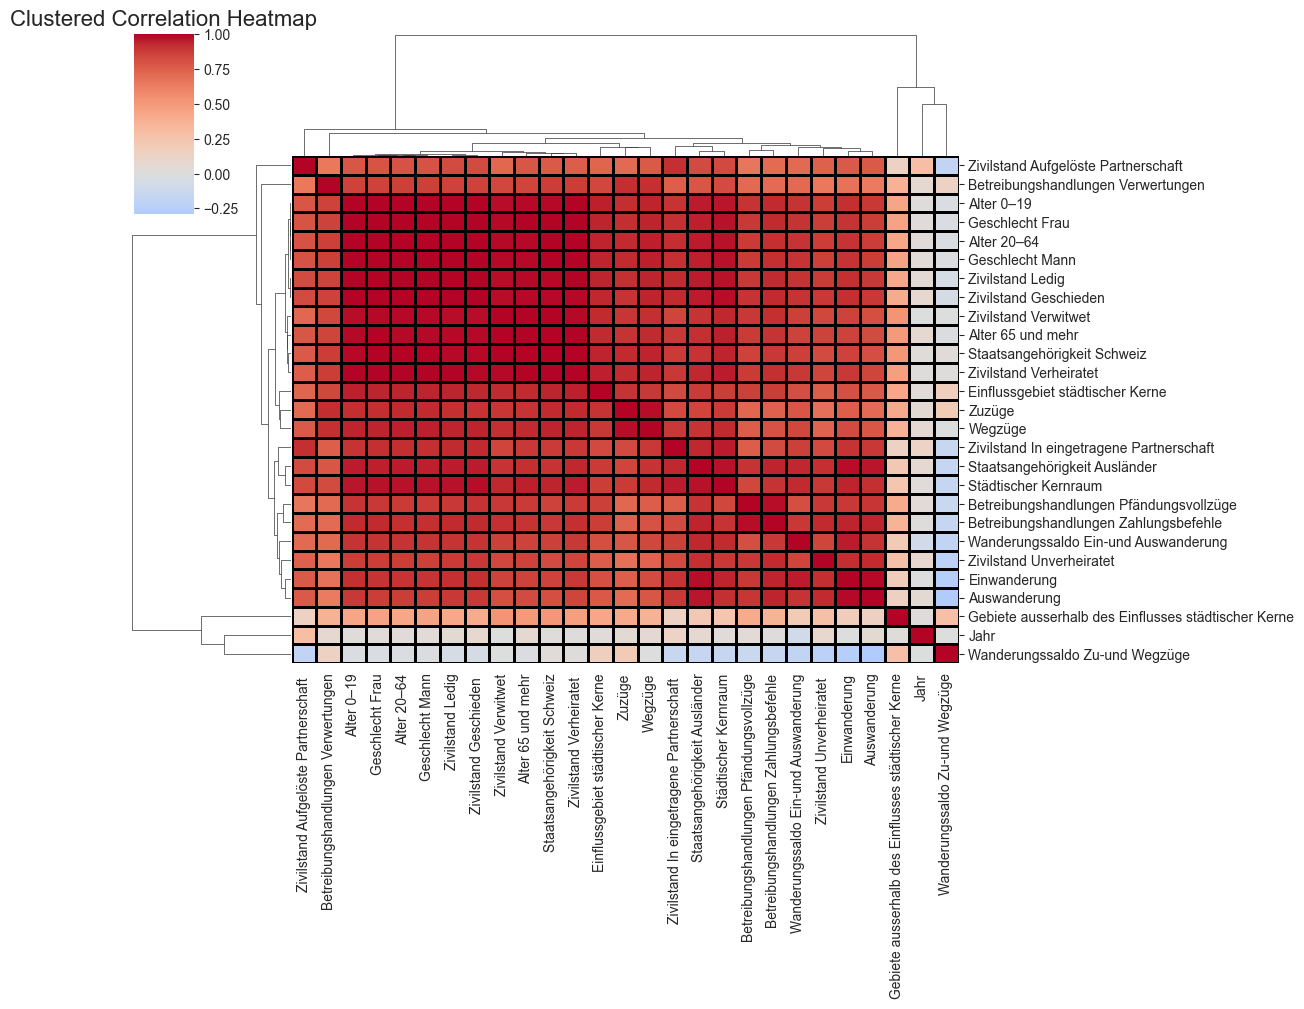

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Set up the figure
plt.figure(figsize=(12, 10))

# Use seaborn's clustermap for clustering the features based on correlation patterns
sns.clustermap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=1, linecolor='black', figsize=(12, 10))

# Add a title
plt.title('Clustered Correlation Heatmap', fontsize=16)

output_path = '../plots/clusteredCorrelationHeatmap.png'
plt.savefig(output_path, bbox_inches='tight')  # Ensure everything is within the saved figure

plt.show()


In [77]:
from scipy.stats import shapiro
import pandas as pd

df = pd.read_excel('../data/merged_canton/Kantonsdaten_merged_filled_reduced.xlsx')
shapiro_test_results = {}

# Loop over numeric columns to perform the Shapiro-Wilk test
for col in df.select_dtypes(include=['number']).columns:
    # Perform the Shapiro-Wilk test
    stat, p_value = shapiro(df[col].dropna())
    shapiro_test_results[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value}

# Convert the results into a DataFrame for easier visualization
shapiro_test_results_df = pd.DataFrame(shapiro_test_results).T

# Display the top 20 results
print(shapiro_test_results_df.head(20))

                                                    Shapiro-Wilk Statistic  \
Jahr                                                              0.942180   
Alter 0–19                                                        0.792311   
Gebiete ausserhalb des Einflusses städtischer K...                0.759827   
Wanderungssaldo Zu-und Wegzüge                                    0.953050   
Betreibungshandlungen Pfändungsvollzüge                           0.842620   

                                                         p-value  
Jahr                                                3.390404e-10  
Alter 0–19                                          1.975409e-20  
Gebiete ausserhalb des Einflusses städtischer K...  7.684748e-22  
Wanderungssaldo Zu-und Wegzüge                      6.753568e-09  
Betreibungshandlungen Pfändungsvollzüge             7.028313e-18  


In [78]:
output_directory_final = "../data/final"
file_path_double_digit = os.path.join(output_directory_final, "merged_double_digit.csv")
df = pd.read_excel('../data/merged_canton/Kantonsdaten_merged_filled.xlsx')
#df drop all columns except Kanton, Jahr, Alter 0-19, Gebiete ausserhalb des Einflusses städtischer Kerne, Wanderungssaldo Zu-und Wegzüge, Betreibungshandlungen Pfändungsvollzüge

df = df[['Kanton', 'Jahr', 'Alter 0–19', 'Gebiete ausserhalb des Einflusses städtischer Kerne', 'Wanderungssaldo Zu-und Wegzüge', 'Betreibungshandlungen Pfändungsvollzüge']]

df_double_digit = pd.read_csv(file_path_double_digit)


merged_df = pd.merge(df_double_digit, df, how='outer', left_on=['Region', 'Year'], right_on=['Kanton', 'Jahr'])
merged_df = merged_df[merged_df['Region'] != 0]
merged_df.drop('Kanton', axis=1, inplace=True)
merged_df.drop('Jahr', axis=1, inplace=True)

#drop rows where column Jahr is NaN
merged_df = merged_df.dropna(subset=['Year'])


merged_output_path = os.path.join(output_directory_final, "merged_complete.csv")
merged_df.to_csv(merged_output_path, index=False)


In [79]:
merged_df.info()

# 
merged_dfdf = merged_df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 10784 entries, 0 to 10783
Data columns (total 11 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Year                                                 10784 non-null  float64
 1   Region                                               10784 non-null  object 
 2   Acc-ID                                               10784 non-null  float64
 3   Realized                                             10784 non-null  float64
 4   Budget y                                             10784 non-null  float64
 5   Budget y+1                                           10784 non-null  float64
 6   Slack                                                10784 non-null  float64
 7   Alter 0–19                                           10784 non-null  int64  
 8   Gebiete ausserhalb des Einflusses städtischer Kerne  10784 non-null  in

/var/folders/s1/rdjg15w52m7d40wd79ksjgq40000gn/T/ipykernel_52846/1457315937.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df['Realized'])


<Axes: xlabel='Realized', ylabel='Density'>

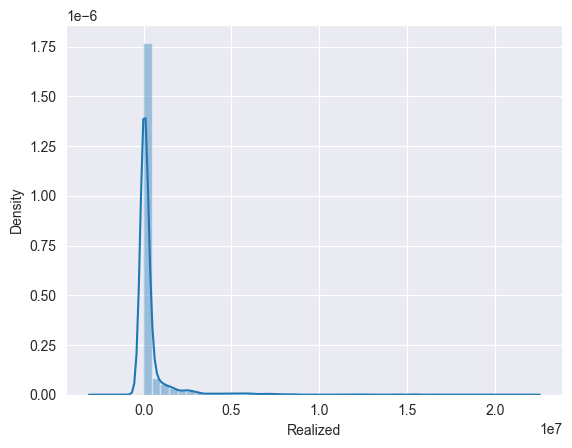

In [80]:
import seaborn as sns
sns.distplot(merged_df['Realized'])

/var/folders/s1/rdjg15w52m7d40wd79ksjgq40000gn/T/ipykernel_52846/338732076.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_df['Realized'])


<Axes: xlabel='Realized', ylabel='Density'>

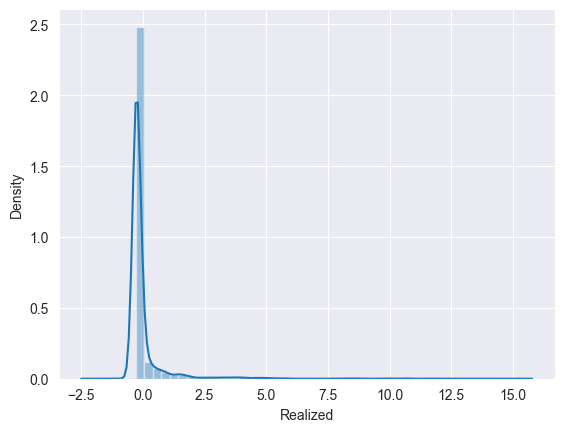

In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_df['Realized'] = scaler.fit_transform(merged_df[['Realized']])
sns.distplot(merged_df['Realized'])

In [82]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd
from typing import List, Optional

# Feature Engineering Functions

def apply_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df_mod = df.copy()
    required_columns = ["Year", "Realized"]
    missing_columns = [col for col in required_columns if col not in df_mod.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Define lags
    one_year_lag = 1
    two_year_lag = 2

    # Create lag features for 'Realized'
    df_mod["Realized_1yr_lag"] = df_mod.groupby(["Region", "Acc-ID"])["Realized"].shift(one_year_lag)
    df_mod["Realized_2yr_lag"] = df_mod.groupby(["Region", "Acc-ID"])["Realized"].shift(two_year_lag)

    return df_mod

def apply_lag_features(df: pd.DataFrame, lag_columns: List[str], lags: List[int]) -> pd.DataFrame:
    df_mod = df.copy()
    for col in lag_columns:
        for lag in lags:
            lag_col_name = f"{col}_{lag}yr_lag"
            df_mod[lag_col_name] = df_mod.groupby(["Region", "Acc-ID"])[col].shift(lag)
    return df_mod

def drop_all_zero_entries(df: pd.DataFrame) -> pd.DataFrame:
    condition1 = (df["Realized"] != 0) | (df["Budget y"] != 0)
    condition2 = ~((df["Budget y"] == 0) & (df["Acc-ID"].isin([10, 14, 20, 29])))
    filtered_df = df[condition1 & condition2]
    return filtered_df

def choose_acc_ids(df: pd.DataFrame, acc_ids: Optional[List[int]]) -> pd.DataFrame:
    df_mod = df.copy()
    if acc_ids is None:
        return df_mod
    return df_mod[df_mod["Acc-ID"].isin(acc_ids)]

def engineer_df(df: pd.DataFrame, acc_ids: Optional[List[int]]) -> pd.DataFrame:
    df_mod = df.copy()
    df_mod = df_mod.sort_values(by="Year")
    df_mod = apply_feature_engineering(df_mod)
    # lag_columns = ['Budget y']  # Specify columns to lag
    # df_mod = apply_lag_features(df_mod, lag_columns, [1, 2])  
    df_mod = drop_all_zero_entries(df_mod)
    df_mod = choose_acc_ids(df_mod, acc_ids)
    return df_mod

# Applying feature engineering on the merged_df DataFrame
# Specify the account IDs you want to include, or set to None to include all
acc_ids = None  # You can change this to a list of specific Account IDs if needed
merged_df = engineer_df(merged_df, acc_ids)
#drop column Budget y+1 and Budget y and Slack
# merged_df = merged_df.drop('Budget y+1', axis=1)
# merged_df = merged_df.drop('Budget y', axis=1)
# merged_df = merged_df.drop('Slack', axis=1)

# Ensure that only numeric columns are used for correlation calculation
X = merged_df.drop(columns=['Realized']).select_dtypes(include=['number'])
y = merged_df['Realized']

# Initialize lists to store correlations
pearson_corr = []
spearman_corr = []

# Calculate Pearson and Spearman correlations for each feature with 'Realized'
for col in X.columns:
    X_col = X[col].fillna(0)
    y_filled = y.fillna(0)

    pearson_corr_value, _ = pearsonr(X_col, y_filled)
    pearson_corr.append(pearson_corr_value)
    
    spearman_corr_value, _ = spearmanr(X_col, y_filled)
    spearman_corr.append(spearman_corr_value)

# Create a DataFrame to store and compare results
correlation_df = pd.DataFrame({
    'Feature': X.columns,
    'Pearson Correlation': pearson_corr,
    'Spearman Correlation': spearman_corr
}).sort_values(by='Pearson Correlation', ascending=False)

# Display the correlation results
print(correlation_df)

# Set a correlation threshold
threshold = 0.3

# Filter out features with Pearson or Spearman correlations below the threshold
strong_features = correlation_df[
    (correlation_df['Pearson Correlation'].abs() >= threshold) | 
    (correlation_df['Spearman Correlation'].abs() >= threshold)
]

weak_features = correlation_df[
    (correlation_df['Pearson Correlation'].abs() < threshold) &
    (correlation_df['Spearman Correlation'].abs() < threshold)
]


# Extract the names of the strong features
strong_feature_names = strong_features['Feature'].tolist()

weak_features_names = [feature for feature in weak_features['Feature'].tolist() if feature != 'Year']


merged_dfdf = merged_dfdf.drop(weak_features_names, axis=1)

# Save the updated DataFrame
output_path = '../data/final/merged_complete_filtered.csv'
merged_dfdf.to_csv(output_path, index=False)

                                              Feature  Pearson Correlation  \
2                                            Budget y             0.977569   
3                                          Budget y+1             0.977360   
9                                    Realized_1yr_lag             0.912183   
10                                   Realized_2yr_lag             0.850202   
5                                          Alter 0–19             0.318967   
8             Betreibungshandlungen Pfändungsvollzüge             0.295096   
6   Gebiete ausserhalb des Einflusses städtischer ...             0.195377   
0                                                Year             0.065926   
7                      Wanderungssaldo Zu-und Wegzüge            -0.047373   
1                                              Acc-ID            -0.323474   
4                                               Slack            -0.327562   

    Spearman Correlation  
2               0.948313  
3        

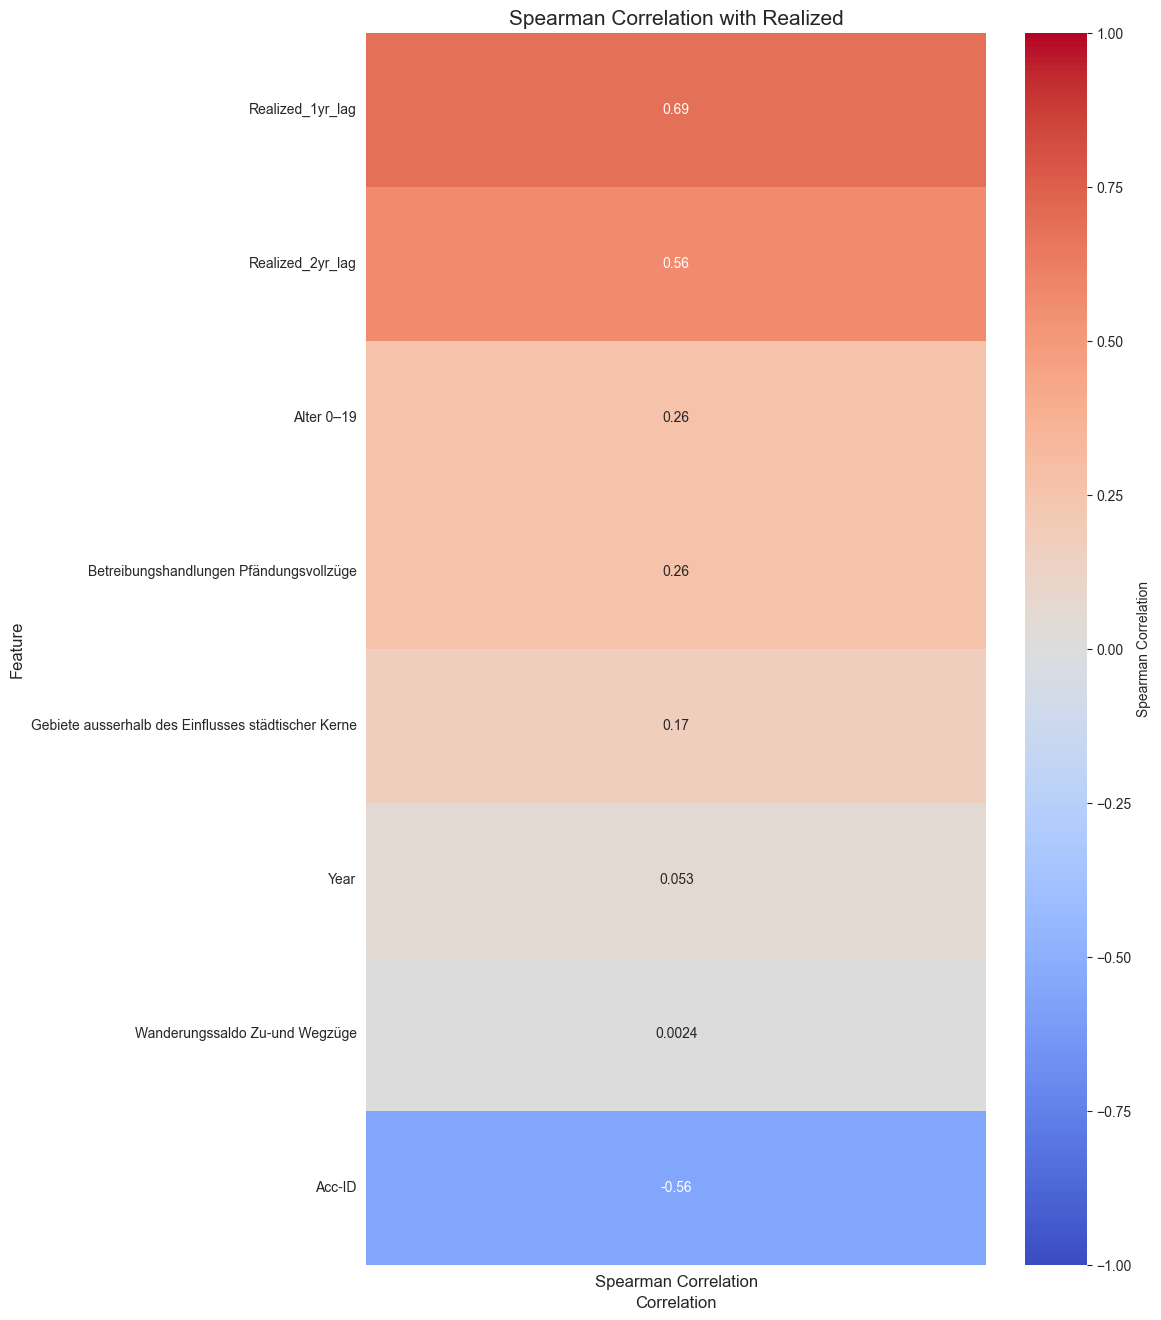

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame to store Spearman correlations for plotting
spearman_corr_df = pd.DataFrame({
    'Feature': X.columns,
    'Spearman Correlation': spearman_corr
}).sort_values(by='Spearman Correlation', ascending=False).set_index('Feature')

# Drop the variables "Slack" and "Budget Y"
spearman_corr_df = spearman_corr_df.drop(['Slack', 'Budget y', 'Budget y+1'], errors='ignore')

# Plotting the heatmap
plt.figure(figsize=(10, 16))  # Increased figure size
sns.heatmap(spearman_corr_df, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Spearman Correlation'}, annot_kws={"size": 10})

# Rotate the y-axis labels for better readability
plt.yticks(rotation=0, fontsize=10)  # Keep labels horizontal but adjust font size
plt.xticks(fontsize=12)

plt.title('Spearman Correlation with Realized', fontsize=15)
plt.ylabel('Feature', fontsize=12)
plt.xlabel('Correlation', fontsize=12)

# Save the plot before displaying it
output_path = '../plots/spearman_correlation_heatmap.png'
plt.savefig(output_path, bbox_inches='tight')  # Ensure everything is within the saved figure

# Display the plot
plt.show()


<Figure size 1200x1000 with 0 Axes>

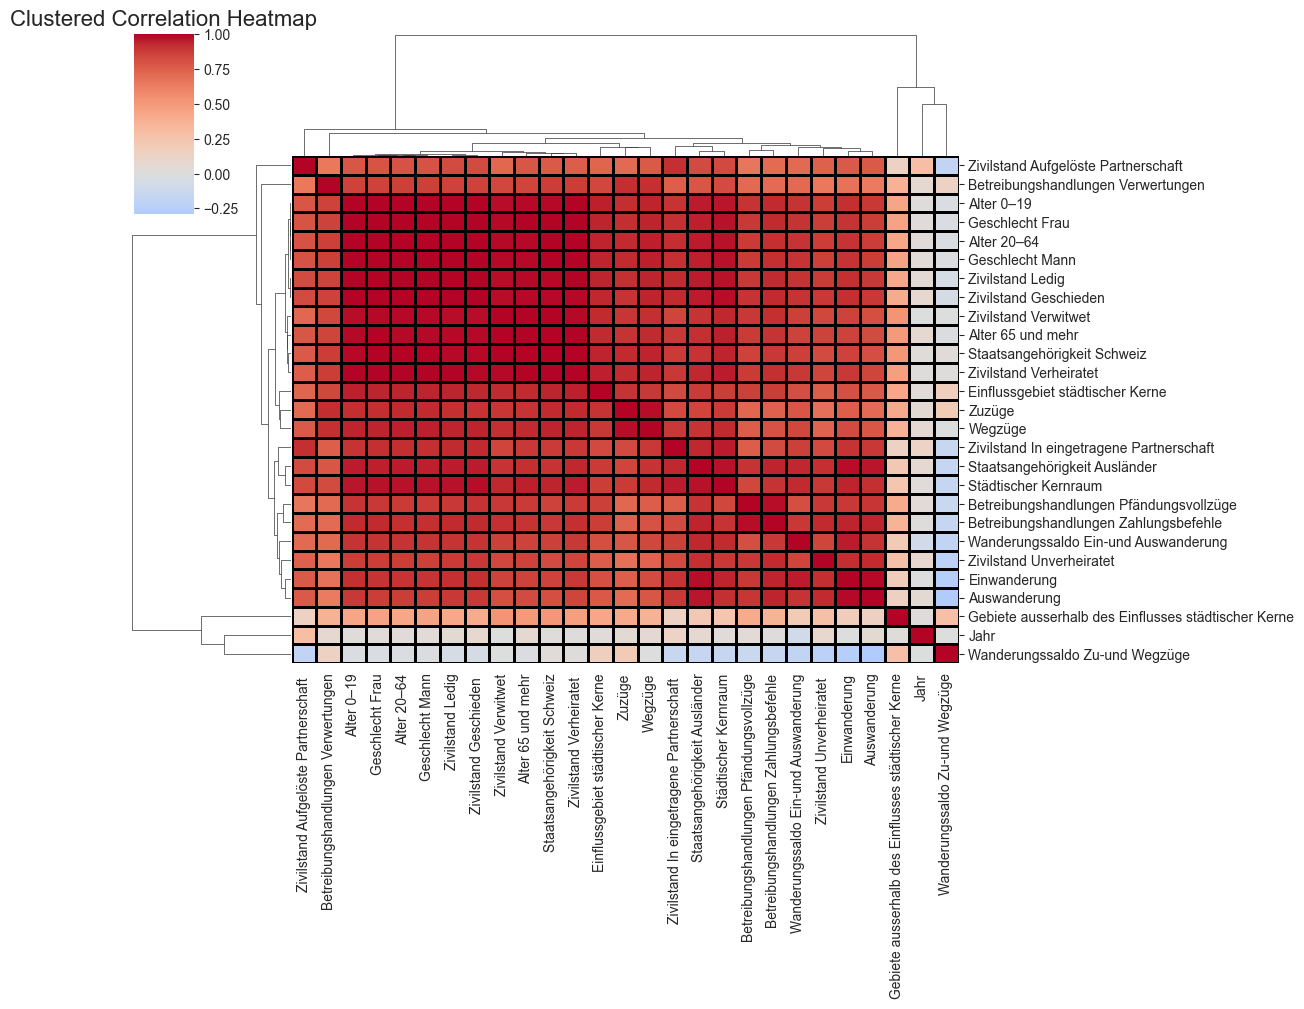

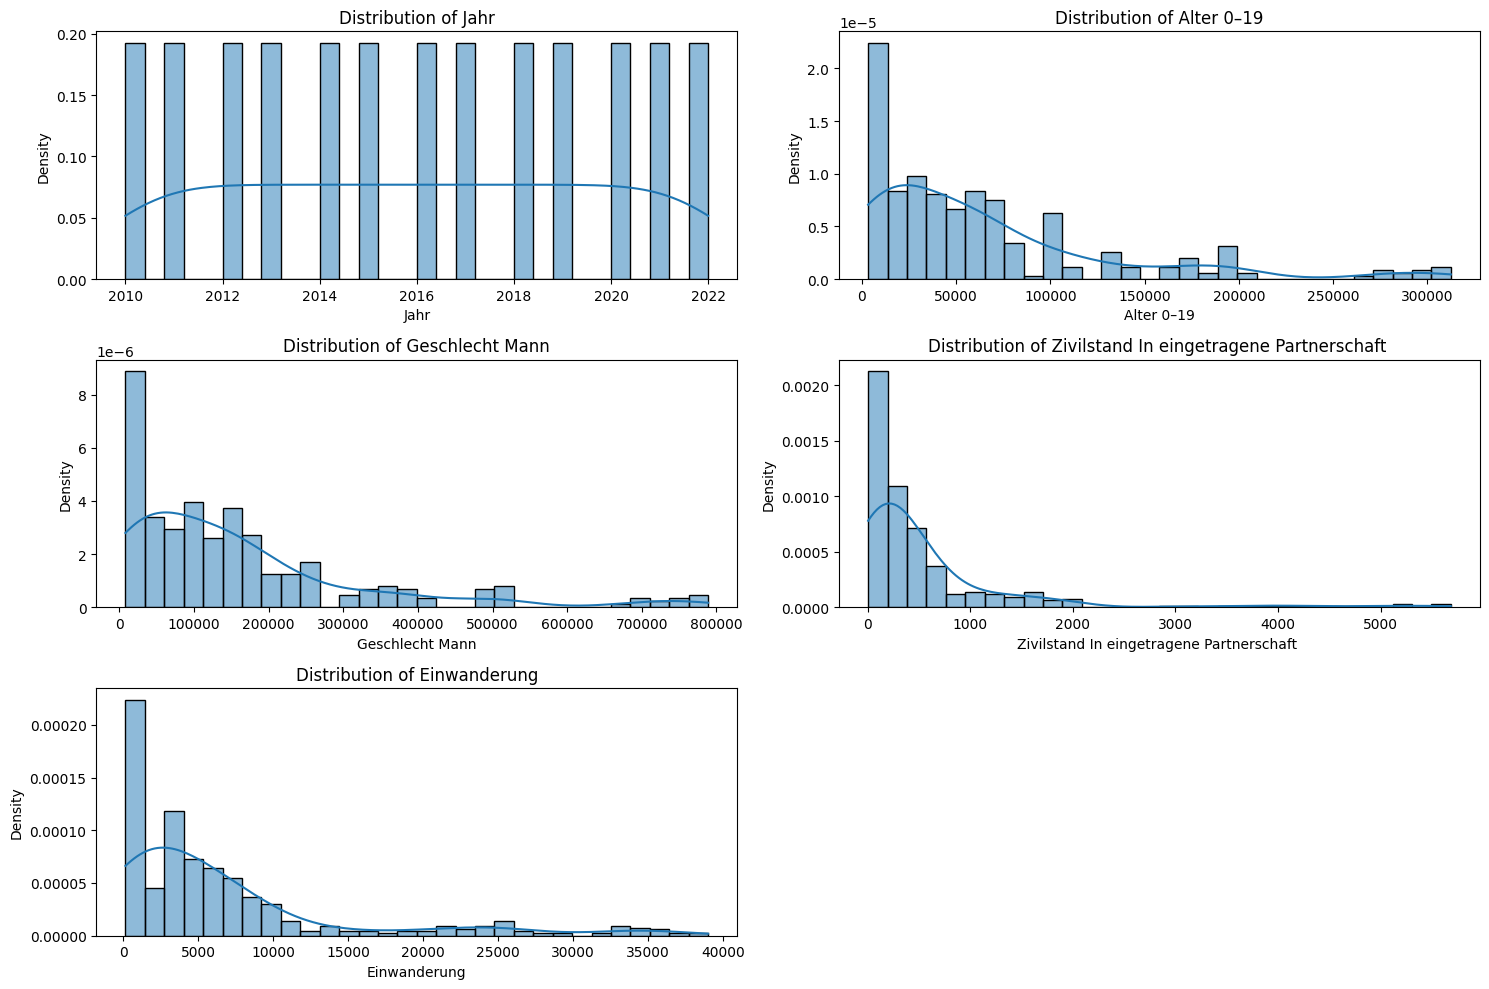

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('../data/merged_canton/Kantonsdaten_merged.xlsx')

# Select a few representative columns for plotting
columns_to_plot = ['Jahr', 'Alter 0–19', 'Geschlecht Mann', 'Zivilstand In eingetragene Partnerschaft ', 'Einwanderung']

# Set up the plotting environment
plt.figure(figsize=(15, 10))

# Plot histograms and KDE plots for the selected columns
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col].dropna(), kde=True, stat="density", bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()
